<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw10/combine_factors_and_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CMPE 257 - MLSprings 2021 Cohort
Objective: Detect fake news in political datasets using factors
mircro factors <br />
Team DataCorps - Yuxing Wang, Arun Talkad, Mayuri Lalwani

## True-o-meter Pipeline

Micorfactors for Factor - Sychology Utilities, Yuxing
* Sentiment
* Group confirmation
* Opinion leader

Micorfactors for Factor - Intent, Mayuri
* Utterance
* Speech
* Sentiment

Micorfactors for Factor -Incredibility, Arun
* Incredibility

Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c
* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


## 1.Data Preparation
* Scrape data from politifact
* Fetch twitter tweets by APIs

###1.1.Scrape data from politifact

In [1]:
!pip install -q beautifulsoup4
!pip install -q vaderSentiment

**Import Required Packages**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re
import requests
import string
from string import punctuation
from sklearn.preprocessing import StandardScaler
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def scrape_data_from_politifact(start=1, end=10):
  url = "https://www.politifact.com/issues/"
  issues = []
  r = requests.get(url)
  soup = BeautifulSoup(r.text,'html.parser')
  results = soup.find_all('div', attrs={'class':'c-chyron__value'})
  for result in results:
    name = result.find('a').text
    issue = result.find('a')['href'].replace("/","")
    issues.append((name, issue))
  url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

  records = []  

  for i in range(1,10):
    for issue, issue_url in issues[0:5]:
      fUrl = url.format(pgno=str(i), category=issue_url)
      r = requests.get(fUrl)
      soup = BeautifulSoup(r.text, 'html.parser')  
      results = soup.find_all('article', attrs={'class':'m-statement'})
      for result in results:
        date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
        reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
        author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
        statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
        statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
        article_url =  result.find('a')['href']
        verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
        records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  return records

records = scrape_data_from_politifact()
df_politifact = pd.DataFrame(records,
                         columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_politifact.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"May 7, 2021",Abortion,Bill McCarthy,Facebook posts,"Says Chelsea Clinton tweeted, ""If Jesus were a...","stated on May 7, 2021 in a Facebook post:",pants-fire,/personalities/facebook-posts/
1,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
2,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
3,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
4,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/


###1.2.Scrape data from twitter

In [4]:
!pip install -q datasketch
!pip install -q networkx 

In [5]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from datasketch import MinHash, MinHashLSH

In [6]:
def scrape_data_from_twitter():
  access_token = '1311987544507084800-iYuPqERzopIZuuyxaZ8xnqARcyKrR1'
  access_token_secret = 'DCJg5kE7srBZRToNlzF0xqT3hcxonnXMlMXKWjX91wyTe'
  consumer_key = 'YQLJJb0ELY5pdXbx7WkQXtRXo'
  consumer_secret = 'HCgQga7Mj33C5E19IP7Dr3qGChmc85M6IEYXSGtI6g4cdplBYw'

  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)

  api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

  tweets = []

  count = 1

  """if you don't add since= as one of the parameters, Twitter will sample the last 7 days worth of data depending
  on how many total tweets there are with the specific hashtag, keyword, or key phrase that you are looking for. You can
  manually add in the number of items (or tweets) you want to get back in the items() section."""

  for tweet in tweepy.Cursor(api.search, q="#breaking", count=450, since='2020-04-10', lang='en').items(5000):
    count += 1
    try:
      data = [tweet.text, tweet.retweet_count, tweet.user.followers_count]
      data = tuple(data)
      tweets.append(data)
    
    except tweepy.TweepError as e:
      print(e.reason)
      continue

    except StopIteration:
      break
  return tweets

tweets = scrape_data_from_twitter()
df_tweet = pd.DataFrame(tweets, columns = ['Statement', 'NumOfRetweets', 'UserNumOfFollowers'])
df_tweet = df_tweet[:1000]
df_tweet.head()

,Statement,NumOfRetweets,UserNumOfFollowers
0,RT @ABC7: #BREAKING California reports first y...,105,24
1,RT @Plchakraborty: #Breaking| West Bengal CID ...,760,2795
2,RT @Saudi_Gazette: #BREAKING: The Custodian of...,92,269
3,RT @HinduAmerican: #Breaking: @HinduAmerican f...,63,30
4,#BREAKING: The Custodian of the Two Holy Mosqu...,0,2523


###1.3.Scrapte data from newsapi

In [7]:
 def scrape_data_from_newsapi():
   # BBC news api
   my_url = "https://newsapi.org/v2/top-headlines?country=us&category=general&apiKey=4aa01326eb3147a881ad8f93863c9663"
   my_open_bbc_page = requests.get(my_url).json()
   my_article = my_open_bbc_page["articles"]
   my_results = []
   for ar in my_article:
      my_results.append(ar["title"])

   return my_results

news = scrape_data_from_newsapi()
df_news = pd.DataFrame(news, columns = ['Statement'])
df_news.head()

,Statement
0,Five takeaways on a surprisingly poor jobs rep...
1,Zion Williamson out indefinitely with fracture...
2,Mike Holmgren: Packers not handling Aaron Rodg...
3,Resident Evil Village Sets New Series Record W...
4,CDC website now emphasizes coronavirus spreads...


**Text Preprocessing**

In [8]:
df = df_tweet.copy()

In [9]:
stopwords = stopwords.words('english')
stopwords.append(['breaking', 'BREAKING'])

def get_text_processing(text):
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stopwords])

In [10]:
df['Statement'] = df['Statement'].apply(get_text_processing)

##2.Individual Work

### 2.1.Microfactors generation (Yuxing)

**Generate Microfactors for Factor PsychologyUtilites**

**1. Group Confirmation**

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for a 'strong' confirmation or not.

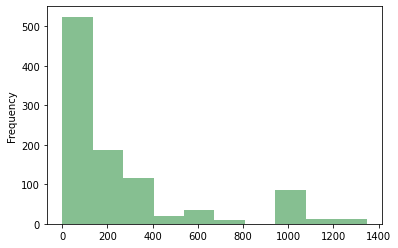

In [11]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df.NumOfRetweets, 99)
df['NumOfRetweets'].loc[df['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df.NumOfRetweets.values, 1)
df['NumOfRetweets'].loc[df['NumOfRetweets']<llimit] = llimit
df['NumOfRetweets'].plot.hist(color='#86bf91')

In [12]:
def gen_microfactor_confirmation(df):
  df['ScaleConfirmation'] = df['NumOfRetweets']/df['NumOfRetweets'].mean()
  df['ScaleConfirmation'] = df['ScaleConfirmation'].apply(lambda x: 1 if x > 1 else x)
  df['Confirmation'] = df['ScaleConfirmation'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_confirmation(df)

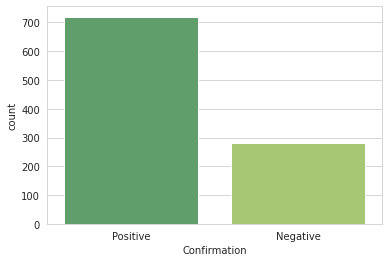

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df, palette='summer')

**2. Author Sentiment**

We use SentimentIntensityAnalyzer to detect the score of sentiment.

In [14]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return abs(_sentiment)

In [15]:
df['ScaleSentiment'] = df['Statement'].apply(get_text_sentiment)
df['Sentiment'] = df['ScaleSentiment'].apply(lambda x: 'Positive' if float(x) > 0.4 else 'Negative')

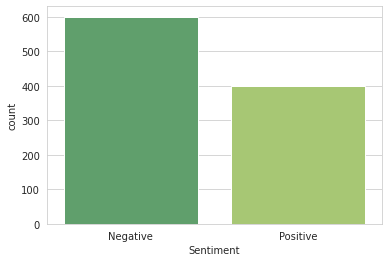

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df, palette='summer')

**3. Opinion Leader**

The opinion leaders are people who have many followers, we will use use number of followers of twitter user to detect the score of opinion leader.

In [17]:
def gen_microfactor_opinionleader(df):
  df['ScaleOpinionLeader'] = df['UserNumOfFollowers']/df['UserNumOfFollowers'].mean()
  df['ScaleOpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 1 if x > 1 else x)
  df['OpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_opinionleader(df)

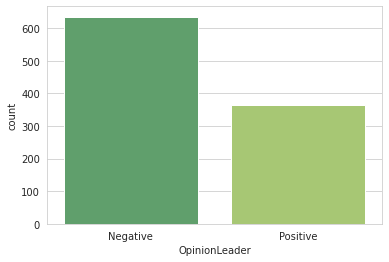

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='OpinionLeader',data=df, palette='summer')

###2.2.Factor generation(Yuxing)
* Combine micro-factors to factor PsychologyUtilites using polynomial

In [19]:
# Get factor from micro factors by polynomial
df['ScalePsychology'] = df['ScaleConfirmation'] * 0.34 + df['ScaleSentiment'] * 0.33 + df['ScaleOpinionLeader'] * 0.33
df['PsychologyUtilites'] = df['ScalePsychology'].apply(lambda x: 'Positive' if x > 0.3 else 'Negative')

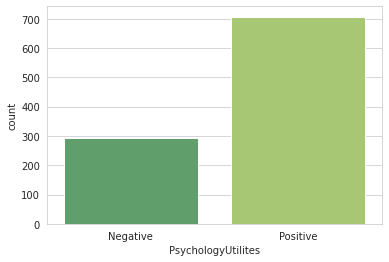

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='PsychologyUtilites',data=df, palette='summer')

In [21]:
df.shape

(1000, 11)

**Construct a pipeline model with count vector Tfidf vector inside**

Pipeline includes vectorization tfidf transformer and SVM training

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# A pipeline with data preprocessing, training and prediction
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1, probability=True))
])

def data_to_pipeline(df, _source=None, _target=None):
  # Split data for training and validation
  X, y = df[_source].values, df[_target].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
  
  # Training and prediction
  pipeline.fit(X_train, y_train)
  scores = cross_val_score(pipeline, X_test, y_test, cv=3)
  print('now using %s to predict %s' % (_source, _target))
  print('cross validation scores:', scores)
  print('prediction score:', pipeline.score(X_test, y_test))

  # Save the pickle file
  pickle_filepath = '/content/' + _target + '_pipeline.pkl'
  joblib.dump(pipeline, pickle_filepath)
  print('pickle file is created:', pickle_filepath)
  print('\n')

In [23]:
def factor_1_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Sentiment')
  data_to_pipeline(df, _source='Statement', _target='Confirmation')
  data_to_pipeline(df, _source='Statement', _target='OpinionLeader')
  data_to_pipeline(df, _source='Statement', _target='PsychologyUtilites')

factor_1_pipeline(df)

now using Statement to predict Sentiment
cross validation scores: [0.94 0.94 0.9 ]
prediction score: 0.9633333333333334
pickle file is created: /content/Sentiment_pipeline.pkl


now using Statement to predict Confirmation
cross validation scores: [0.93 0.99 0.93]
prediction score: 0.9766666666666667
pickle file is created: /content/Confirmation_pipeline.pkl


now using Statement to predict OpinionLeader
cross validation scores: [0.67 0.63 0.64]
prediction score: 0.69
pickle file is created: /content/OpinionLeader_pipeline.pkl


now using Statement to predict PsychologyUtilites
cross validation scores: [0.83 0.78 0.9 ]
prediction score: 0.8566666666666667
pickle file is created: /content/PsychologyUtilites_pipeline.pkl




### 2.3.Microfactors generation (Mayuri)

**Generate Microfactors for Factor Intent**

**1. Utterance Score**

Where there are more sentences, there are more utterances. We can derive utterance from numberof sentences in the text.

In [24]:
from collections import Counter
import spacy

nlp = spacy.load('en_core_web_sm')

def get_sentences_num(text):
  _doc = nlp(text)
  sentences = list(_doc.sents)
  return len(sentences)

df['NumOfSent'] = df['Statement'].apply(get_sentences_num)

In [25]:
def gen_microfactor_utterance(df):
  df['ScaleUtterance'] = df['NumOfSent']/df['NumOfSent'].mean()
  df['ScaleUtterancen'] = df['ScaleUtterance'].apply(lambda x: 1 if x > 1 else x)
  df['Utterance'] = df['ScaleUtterance'].apply(lambda x: 'Positive' if x > 0.9 else 'Negative')

gen_microfactor_utterance(df)

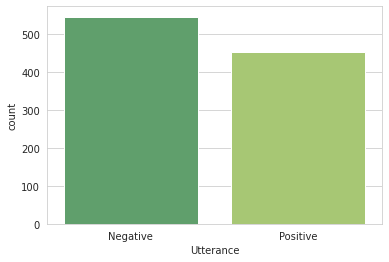

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='Utterance',data=df, palette='summer')

**2.Speech Score**

Where there are more verbs and nouns, there are more speech to make. We can derive speech from numberof verbs and nouns in the text.

In [27]:
def get_verbnoun_num(text):
  _doc = nlp(text)
  _no_stopword_doc = [token for token in _doc if not token.is_stop]
  return len(_no_stopword_doc)

df['NumOfVerbNoun'] = df['Statement'].apply(get_verbnoun_num)

In [28]:
def gen_microfactor_speech(df):
  df['ScaleSpeech'] = df['NumOfVerbNoun']/df['NumOfVerbNoun'].mean()
  df['ScaleSpeech'] = df['ScaleSpeech'].apply(lambda x: 1 if x > 1 else x)
  df['Speech'] = df['ScaleSpeech'].apply(lambda x: 'Positive' if x > 0.95 else 'Negative')

gen_microfactor_speech(df)

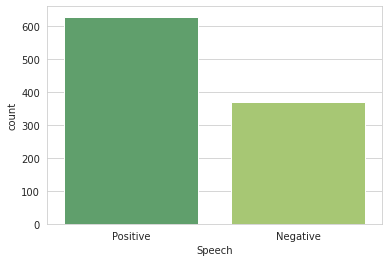

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='Speech',data=df, palette='summer')

**3.Sentiment**

Sentiment is a micro factor of intent, also it is micro factor of psychology utility, which has been derived earlier.

In [30]:
df['ScaleSentiment'].head()

0    0.2732
1    0.2023
2    0.6908
3    0.0000
4    0.6908
Name: ScaleSentiment, dtype: float64

### 2.4.Factor generation(Mayuri)
* Combine micro-factors to factor Intent using polynomial

In [31]:
# Get factor from micro factors by polynomial
df['ScaleIntent'] = df['ScaleUtterancen'] * 0.3 + df['ScaleSpeech'] * 0.3 + df['ScaleSentiment'] * 0.4
df['Intent'] = df['ScaleIntent'].apply(lambda x: 'Positive' if x > 0.65 else 'Negative')

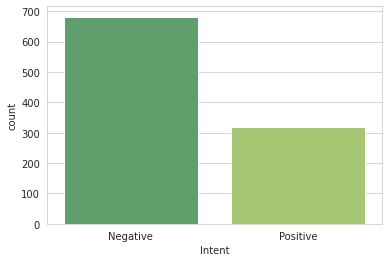

In [32]:
sns.set_style('whitegrid')
sns.countplot(x='Intent',data=df, palette='summer')

In [33]:
def factor_2_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Utterance')
  data_to_pipeline(df, _source='Statement', _target='Speech')
  data_to_pipeline(df, _source='Statement', _target='Intent')

factor_2_pipeline(df)

now using Statement to predict Utterance
cross validation scores: [0.89 0.93 0.92]
prediction score: 0.9633333333333334
pickle file is created: /content/Utterance_pipeline.pkl


now using Statement to predict Speech
cross validation scores: [0.94 0.96 0.96]
prediction score: 0.9466666666666667
pickle file is created: /content/Speech_pipeline.pkl


now using Statement to predict Intent
cross validation scores: [0.92 0.95 0.91]
prediction score: 0.9666666666666667
pickle file is created: /content/Intent_pipeline.pkl




## 3.Team Work

###3.1.Load the pickled models for microfactors

In [34]:
! ls -l /content/*.pkl

-rw-r--r-- 1 root root 122564 May  7 23:04 /content/Confirmation_pipeline.pkl
-rw-r--r-- 1 root root 118784 May  7 23:08 /content/Intent_pipeline.pkl
-rw-r--r-- 1 root root 183641 May  7 23:04 /content/OpinionLeader_pipeline.pkl
-rw-r--r-- 1 root root 142901 May  7 23:04 /content/PsychologyUtilites_pipeline.pkl
-rw-r--r-- 1 root root 119180 May  7 23:04 /content/Sentiment_pipeline.pkl
-rw-r--r-- 1 root root 118592 May  7 23:08 /content/Speech_pipeline.pkl
-rw-r--r-- 1 root root 121664 May  7 23:08 /content/Utterance_pipeline.pkl
-rw-r--r-- 1 root root  55099 May  7 22:09 /content/Verdict_pipeline.pkl


In [35]:
import joblib

microfactor_list = [
                    'Sentiment', 
                    'Confirmation', 
                    'OpinionLeader',
                    'Utterance',
                    'Speech',
                    'Intent'
                  ]

def get_micrafactor_from_pickles_(df):
  # Preprocessing
  df['Statement'] = df['Statement'].apply(get_text_processing)
  statement = df['Statement'].to_numpy()
  for microfactor in microfactor_list:
    print('generating microfactor :', microfactor)
    # load microfactor pickle
    pickle_filepath = '/content/{}_pipeline.pkl'.format(microfactor)
    microfactor_model = joblib.load(open(pickle_filepath, 'rb'))
    # create new microfact column
    y_microfactor = microfactor_model.predict(statement)
    df[microfactor] = y_microfactor
    df[microfactor] = df[microfactor].apply(lambda x: 1 if x == 'Positive' else 0)
    

###3.2.Ensemble a true-o-meter classification pipeline

**Use politicfact dataset to generate microfactors and train Verdict**

In [36]:
df = df_politifact.copy()
get_micrafactor_from_pickles_(df)

generating microfactor : Sentiment
generating microfactor : Confirmation
generating microfactor : OpinionLeader
generating microfactor : Utterance
generating microfactor : Speech
generating microfactor : Intent


**Use ensembled model and microfactors to train Verdict, model will be pickled in data_to_pipeline processing**

In [37]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('svm', SVC(C=1, probability=True))
])

data_to_pipeline(df, _source = microfactor_list, _target = 'Verdict')

now using ['Sentiment', 'Confirmation', 'OpinionLeader', 'Utterance', 'Speech', 'Intent'] to predict Verdict
cross validation scores: [0.22916667 0.23404255 0.23404255]
prediction score: 0.22535211267605634
pickle file is created: /content/Verdict_pipeline.pkl




###3.3.Automated Inference Pipeline


**Load pickled true-o-meter pipeline**

In [38]:
pickle_filepath = '/content/Verdict_pipeline.pkl'
o_meter_model = joblib.load(open(pickle_filepath, 'rb'))

**Read a new piece of data from politifact**

In [39]:
records = scrape_data_from_politifact(start=12, end=13)
df = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  

**Predict and compare the Verdict**

In [40]:
get_micrafactor_from_pickles_(df)
df['pred_verdict'] = o_meter_model.predict(df[microfactor_list])
df_intestest = df[['Statement', 'Verdict', 'pred_verdict']]
df_intestest.head()

generating microfactor : Sentiment
generating microfactor : Confirmation
generating microfactor : OpinionLeader
generating microfactor : Utterance
generating microfactor : Speech
generating microfactor : Intent


,Statement,Verdict,pred_verdict
0,Says Chelsea Clinton tweeted Jesus alive today...,pants-fire,false
1,“Joe Biden puts prolife groups domestic extrem...,barely-true,false
2,“Innocent lives saved” ending taxpayer funding...,false,false
3,“aborted male fetus” OxfordAstraZeneca “Covid ...,false,false
4,Says Doug Jones voted spend tax dollars latete...,false,false


In [42]:
! ls -l /content/*.pkl

-rw-r--r-- 1 root root 122564 May  7 23:04 /content/Confirmation_pipeline.pkl
-rw-r--r-- 1 root root 118784 May  7 23:08 /content/Intent_pipeline.pkl
-rw-r--r-- 1 root root 183641 May  7 23:04 /content/OpinionLeader_pipeline.pkl
-rw-r--r-- 1 root root 142901 May  7 23:04 /content/PsychologyUtilites_pipeline.pkl
-rw-r--r-- 1 root root 119180 May  7 23:04 /content/Sentiment_pipeline.pkl
-rw-r--r-- 1 root root 118592 May  7 23:08 /content/Speech_pipeline.pkl
-rw-r--r-- 1 root root 121664 May  7 23:08 /content/Utterance_pipeline.pkl
-rw-r--r-- 1 root root  55099 May  7 23:08 /content/Verdict_pipeline.pkl
